<h3 style="background-color: #111; padding: 15px; font: bold 30px arial; color: lightgreen; border: 2px solid lime; border-radius: 8px ; text-align: center">
Solve problem in sheet Excel </h3>

# **The problem statment**
 - The data is contained in only one column.
 - There is no clear separation between each record.
 - The data contains some repetition and randomness.
#  

# Import Librairs 

In [1]:
import pandas as pd 
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path


# **The solution**
 - Use the `Text to Columns` feature in Excel.
 - Select the column with the data.
 - Go to the `Data` tab and click on `Text to Columns`.
 - Choose `Delimited` and click `Next`.
 - Select the delimiter that separates your records (e.g., comma, space, etc.) and click `Finish`.
 - This will split the data into separate columns based on the chosen delimiter.

# **Data info** 

In [2]:
data = pd.read_excel('./Students (1).xlsx')      
path = Path('./Students (1).xlsx')
data.head()

,Unnamed: 0
0,NamearrowTotal LessonsThese are the amount of ...
1,S
2,Offline
3,Sabine
4,English • 111


In [3]:
data.tail()

,Unnamed: 0
8884,Arabic
8885,Native
8886,Send a Lesson Invitation
8887,contact form
8888,message


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8889 entries, 0 to 8888
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8165 non-null   object
dtypes: object(1)
memory usage: 69.6+ KB


# **Converting the data to a suitable format for analysis**

In [5]:
status_list = {
    'Offline', 'Online', 'Busy', 'Away', 'Active', 'Inactive'
}
language_list = {
    'English', 'Korean', 'Czech', 'Italian', 'Spanish', 'French', 'German',
    'Chinese', 'Japanese', 'Arabic', 'Portuguese', 'Russian', 'Hindi'
}
proficiency_list = {
    'Native', 'Fluent', 'Intermediate', 'Beginner', 'Advanced', 'Proficient'
}
ui_ignore = {
    'Send a Lesson Invitation', 'message', 'more', 'Invite', 'Profile', 'View More'
}

rating_pattern = re.compile(r'(.+?)\s*[•·]\s*(\d+)$')
last_active_pattern = re.compile(r'^(?:\d+|a)\s+(?:months?|month|years?|year|days?|day)\s+ago$', re.IGNORECASE)

## **Functions**

In [6]:


def load_column_values(path: str) -> pd.Series:
    df = pd.read_excel(path, header=None)
    col = df.iloc[:, 0].dropna().astype(str).str.strip()
    col = col[col != '']
    return col.reset_index(drop=True)

In [7]:
def detect_record_boundaries(col: pd.Series, status_keywords: set) -> list:
    records = []
    current = []
    for val in col:
        if val in status_keywords:
            if current:
                records.append(current)
            current = [val]
        else:
            if val in ui_ignore or not val:
                continue
            current.append(val)
    if current:
        records.append(current)
    return records

In [8]:
def classify_record(rec: list,
                    status_keywords: set,
                    language_keywords: set,
                    proficiency_keywords: set) -> (dict, set):
    rec_dict = {
        'Status': None,
        'Name': None,
        'Rating_Lang': None,
        'Rating_Value': None,
        'LastActive': None
    }
    unknowns = set()
    if rec and rec[0] in status_keywords:
        rec_dict['Status'] = rec[0]
    else:
        if rec:
            unknowns.add(rec[0])
    idx = 1
    if len(rec) > 1:
        second = rec[1]
        if (not rating_pattern.match(second)
                and not last_active_pattern.match(second)
                and second not in language_keywords
                and second not in proficiency_keywords):
            rec_dict['Name'] = second
            idx = 2
        else:
            unknowns.add(second)
            idx = 2
    languages = []
    proficiencies = []
    while idx < len(rec):
        val = rec[idx]
        if not val or val in ui_ignore:
            idx += 1
            continue
        m = rating_pattern.match(val)
        if m:
            lang = m.group(1).strip()
            val_num = m.group(2).strip()
            rec_dict['Rating_Lang'] = lang
            try:
                rec_dict['Rating_Value'] = int(val_num)
            except ValueError:
                rec_dict['Rating_Value'] = None
            idx += 1
            continue
        if last_active_pattern.match(val):
            rec_dict['LastActive'] = val
            idx += 1
            continue
        if val in language_keywords:
            lang = val
            prof = None
            if idx + 1 < len(rec) and rec[idx + 1] in proficiency_keywords:
                prof = rec[idx + 1]
                idx += 1
            languages.append(lang)
            proficiencies.append(prof)
            idx += 1
            continue
        if val in proficiency_keywords:
            languages.append(None)
            proficiencies.append(val)
            idx += 1
            continue
        unknowns.add(val)
        idx += 1
    for i, (lang, prof) in enumerate(zip(languages, proficiencies), start=1):
        rec_dict[f'Language{i}'] = lang
        rec_dict[f'Proficiency{i}'] = prof
    return rec_dict, unknowns
def process_all(col: pd.Series) -> (pd.DataFrame, pd.DataFrame):
    records = detect_record_boundaries(col, status_list)
    processed = []
    all_unknowns = set()
    for rec in records:
        rec_dict, unknowns = classify_record(rec, status_list, language_list, proficiency_list)
        processed.append(rec_dict)
        all_unknowns.update(unknowns)
    df_processed = pd.DataFrame(processed)
    if all_unknowns:
        df_unknown = pd.DataFrame(sorted(all_unknowns), columns=['UnknownValue'])
    else:
        df_unknown = pd.DataFrame(columns=['UnknownValue'])
    return df_processed, df_unknown

## **Usage**

In [9]:
col = load_column_values(path)


In [10]:
detect_record_boundaries(col, status_list)

[['NamearrowTotal LessonsThese are the amount of lessons that the student has completed with you.Lesson timeThis learning language is based on what the student selected in your contact teacher form. If you only have one teaching language, the system will default to that language as the learning language.Language SkillsActions',
  'S'],
 ['Offline',
  'Sabine',
  'English\xa0•\xa0111',
  '8 months ago',
  'English',
  'German',
  'Native',
  'G'],
 ['Offline',
  'Giancarlo Rocchietti',
  'English\xa0•\xa0100',
  '9 months ago',
  'English',
  'Italian',
  'Native',
  'A'],
 ['Offline',
  'Andrzej Stein',
  'English\xa0•\xa089',
  'Jun 23, 2025 01:15 PM',
  'English',
  'French',
  'Japanese',
  'Polish',
  'Native',
  '+\xa01\xa0more'],
 ['Offline',
  'Hayoung Choi',
  'English\xa0•\xa078',
  '8 months ago',
  'English',
  'Korean',
  'Native'],
 ['Offline',
  'Markéta',
  'English\xa0•\xa073',
  'a year ago',
  'Czech',
  'Native',
  'English',
  'Italian',
  'T'],
 ['Offline',
  'Tom'

In [11]:
df_processed, df_unknown = process_all(col)

In [12]:
df_processed.head()

,Status,Name,Rating_Lang,Rating_Value,LastActive,Language1,Proficiency1,Language2,Proficiency2,Language3,Proficiency3,Language4,Proficiency4
0,None,S,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offline,Sabine,English,111.0,8 months ago,English,None,German,Native,NaN,NaN,NaN,NaN
2,Offline,Giancarlo Rocchietti,English,100.0,9 months ago,English,None,Italian,Native,NaN,NaN,NaN,NaN
3,Offline,Andrzej Stein,English,89.0,None,English,None,French,None,Japanese,None,None,Native
4,Offline,Hayoung Choi,English,78.0,8 months ago,English,None,Korean,Native,NaN,NaN,NaN,NaN


In [13]:
df_unknown.head()

,UnknownValue
0,+ 1 more
1,+ 2 more
2,+ 3 more
3,+ 4 more
4,+ 5 more


In [14]:
df_processed.tail()

,Status,Name,Rating_Lang,Rating_Value,LastActive,Language1,Proficiency1,Language2,Proficiency2,Language3,Proficiency3,Language4,Proficiency4
721,Offline,Natalia,English,1.0,a year ago,English,None,Russian,Native,NaN,NaN,NaN,NaN
722,Offline,Sergey,English,1.0,a month ago,English,None,Russian,Native,NaN,NaN,NaN,NaN
723,Offline,Veronika,English,1.0,5 years ago,English,None,Russian,Native,NaN,NaN,NaN,NaN
724,Offline,akw1986,English,1.0,a year ago,English,None,None,Native,NaN,NaN,NaN,NaN
725,Offline,Naser,English,1.0,4 years ago,Arabic,Native,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Status        725 non-null    object 
 1   Name          726 non-null    object 
 2   Rating_Lang   725 non-null    object 
 3   Rating_Value  725 non-null    float64
 4   LastActive    712 non-null    object 
 5   Language1     556 non-null    object 
 6   Proficiency1  215 non-null    object 
 7   Language2     568 non-null    object 
 8   Proficiency2  452 non-null    object 
 9   Language3     132 non-null    object 
 10  Proficiency3  72 non-null     object 
 11  Language4     6 non-null      object 
 12  Proficiency4  18 non-null     object 
dtypes: float64(1), object(12)
memory usage: 73.9+ KB


In [16]:
df_processed.isna().sum()

Status            1
Name              0
Rating_Lang       1
Rating_Value      1
LastActive       14
Language1       170
Proficiency1    511
Language2       158
Proficiency2    274
Language3       594
Proficiency3    654
Language4       720
Proficiency4    708
dtype: int64

# **Data Cleaning**
 - Handle missing values and convert data types as needed.

## missing values

In [17]:
df_processed['Rating_Lang'] = df_processed['Rating_Lang'].fillna('English')


In [18]:
df_processed['Status'].value_counts()

Status
Offline    722
Online       3
Name: count, dtype: int64

In [19]:
df_processed['Status'] = df_processed['Status'].fillna('Offline')

In [20]:
df_processed['Rating_Value'] = df_processed['Rating_Value'].fillna(0).astype(int)

In [21]:
df_processed['LastActive'] = df_processed['LastActive'].fillna(df_processed['LastActive'].mode()[0])

In [22]:
for col in df_processed.columns:
    if col.startswith('Language') or col.startswith('Proficiency'):
        df_processed[col] = df_processed[col].fillna('Unknown')
        

## convert data types

In [23]:
df_processed.dtypes

Status          object
Name            object
Rating_Lang     object
Rating_Value     int64
LastActive      object
Language1       object
Proficiency1    object
Language2       object
Proficiency2    object
Language3       object
Proficiency3    object
Language4       object
Proficiency4    object
dtype: object

In [24]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Status        726 non-null    object
 1   Name          726 non-null    object
 2   Rating_Lang   726 non-null    object
 3   Rating_Value  726 non-null    int64 
 4   LastActive    726 non-null    object
 5   Language1     726 non-null    object
 6   Proficiency1  726 non-null    object
 7   Language2     726 non-null    object
 8   Proficiency2  726 non-null    object
 9   Language3     726 non-null    object
 10  Proficiency3  726 non-null    object
 11  Language4     726 non-null    object
 12  Proficiency4  726 non-null    object
dtypes: int64(1), object(12)
memory usage: 73.9+ KB


In [25]:
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].astype('category')

In [26]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Status        726 non-null    category
 1   Name          726 non-null    category
 2   Rating_Lang   726 non-null    category
 3   Rating_Value  726 non-null    int64   
 4   LastActive    726 non-null    category
 5   Language1     726 non-null    category
 6   Proficiency1  726 non-null    category
 7   Language2     726 non-null    category
 8   Proficiency2  726 non-null    category
 9   Language3     726 non-null    category
 10  Proficiency3  726 non-null    category
 11  Language4     726 non-null    category
 12  Proficiency4  726 non-null    category
dtypes: category(12), int64(1)
memory usage: 39.3 KB


# **Data Visualization**

C:\Users\DELL\AppData\Local\Temp\ipykernel_6248\129586475.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_processed, x='Status', order=df_processed['Status'].value_counts().index, palette='viridis')


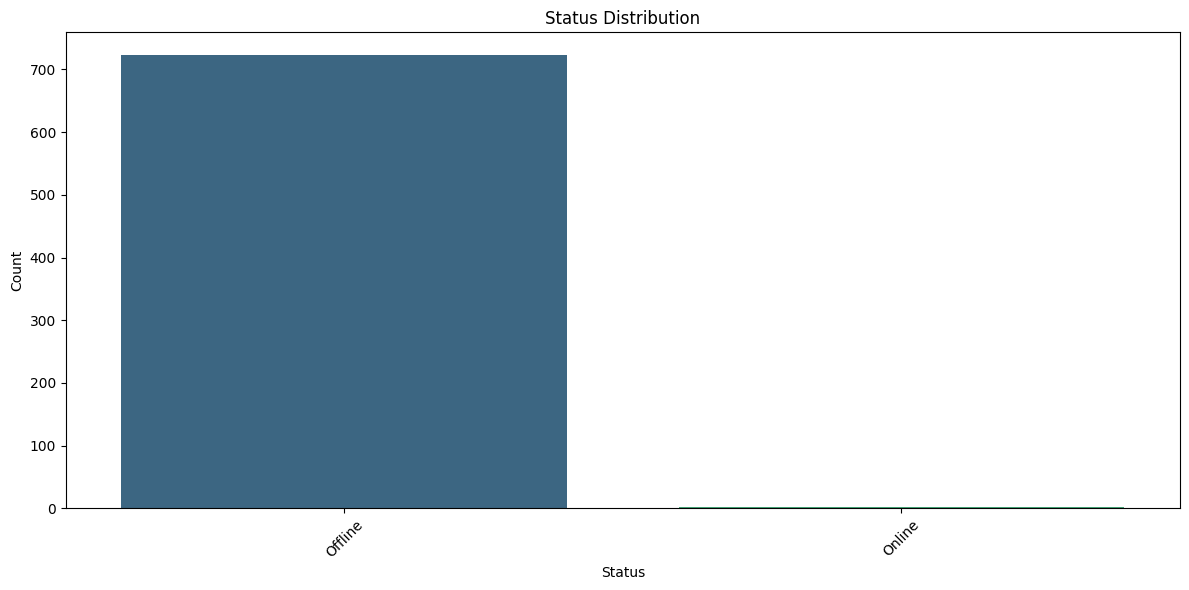

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_processed, x='Status', order=df_processed['Status'].value_counts().index, palette='viridis')
plt.title('Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('status_distribution.png')
plt.show()

<Figure size 1200x600 with 0 Axes>

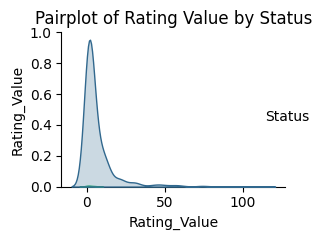

In [28]:
plt.figure(figsize=(12, 6))
sns.pairplot(df_processed, hue='Status', vars=['Rating_Value'], palette='viridis')
plt.title('Pairplot of Rating Value by Status')
plt.tight_layout()
plt.savefig('pairplot_rating_value_by_status.png')
plt.show()

    

C:\Users\DELL\AppData\Local\Temp\ipykernel_6248\1582849920.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_processed, x='LastActive', order=df_processed['LastActive'].value_counts().index, palette='viridis')


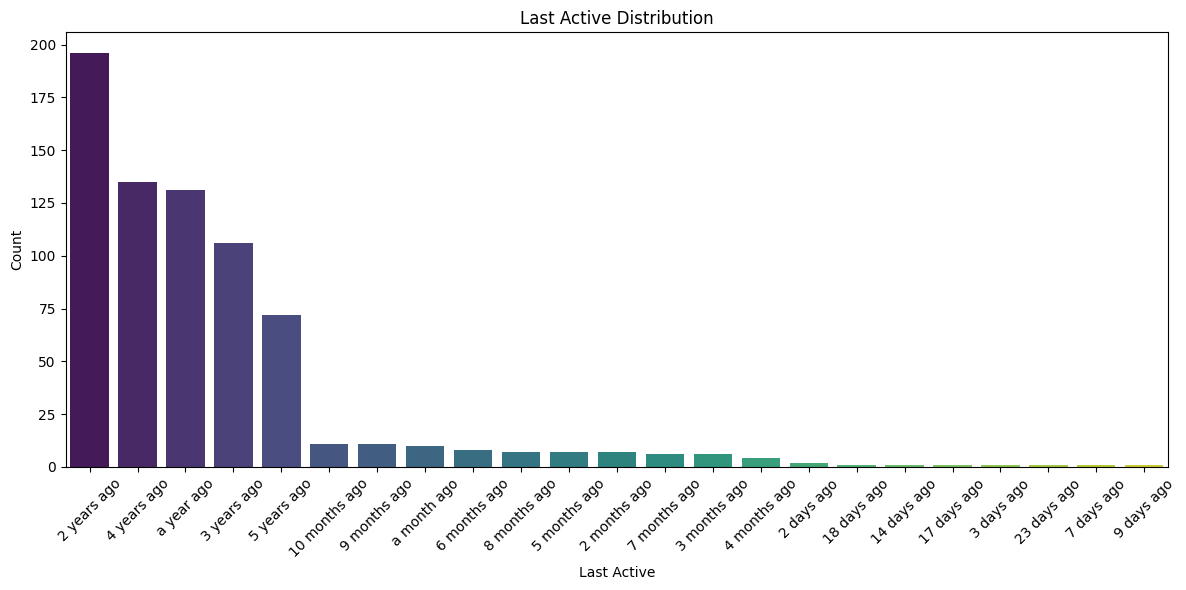

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_processed, x='LastActive', order=df_processed['LastActive'].value_counts().index, palette='viridis')
plt.title('Last Active Distribution')
plt.xlabel('Last Active')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('last_active_distribution.png')
plt.show()

# **Save to Excel**
 

In [30]:

def save_to_excel(df: pd.DataFrame, path: str):
    df.to_excel(path, index=False)
save_to_excel(df_processed, 'processed_students.xlsx')

# **Full script solution in py**


In [ ]:
def complete_excel_parser(file_path='Students-1.xlsx', sheet_name='Sheet2'):
    """
    COMPLETE SOLUTION - Parses unstructured single-column Excel data into structured table
    Handles all edge cases and inconsistencies in the data
    """
    
    # Load the Excel file
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    data = df.iloc[:, 0].fillna('').astype(str)
    
    records = []
    i = 0
    
    # Skip header row if present
    if i < len(data) and 'NamearrowTotal' in str(data.iloc[i]):
        i += 1
    
    def extract_lesson_count(text):
        """Extract lesson count from text like 'English • 111'"""
        match = re.search(r'English\s*•\s*(\d+)', str(text))
        return int(match.group(1)) if match else 0
    
    def is_time_field(text):
        """Check if text represents a time field"""
        text = str(text).lower()
        patterns = [
            r'\d+\s+(months?|years?|days?)\s+ago',
            r'(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)',
            r'\d{4}',  # Year
            r'\d{1,2}:\d{2}\s*(am|pm)',  # Time
            r'a\s+(month|year)\s+ago',
            r'\d+\s+(months?|years?)\s+ago'
        ]
        return any(re.search(pattern, text) for pattern in patterns)
    
    def is_language(text):
        """Check if text is likely a language name"""
        common_langs = [
            'english', 'spanish', 'french', 'german', 'italian', 'portuguese', 'russian',
            'chinese', 'japanese', 'korean', 'arabic', 'hindi', 'dutch', 'polish',
            'czech', 'ukrainian', 'norwegian', 'swedish', 'danish', 'finnish',
            'greek', 'hebrew', 'turkish', 'thai', 'vietnamese', 'romanian',
            'hungarian', 'bulgarian', 'croatian', 'serbian', 'slovenian',
            'lithuanian', 'latvian', 'estonian', 'slovak', 'mandarin', 'cantonese',
            'taiwanese', 'farsi', 'persian', 'urdu', 'bengali', 'punjabi',
            'armenian', 'georgian', 'kazakh', 'azerbaijani', 'belarusian',
            'burmese', 'sinhala', 'somali', 'swahili', 'ladino', 'kurdish',
            'flemish', 'austrian', 'swiss'
        ]
        text_lower = str(text).lower()
        return any(lang in text_lower for lang in common_langs)
    
    def is_record_start(current_idx, data):
        """Determine if current position is start of a new record"""
        if current_idx >= len(data):
            return False
        
        current = str(data.iloc[current_idx])
        next_val = str(data.iloc[current_idx + 1]) if current_idx + 1 < len(data) else ''
        
        # Direct status indicator
        if current in ['Offline', 'Online']:
            return True
        
        # Single character/letter followed by status
        if (len(current) <= 2 and next_val in ['Offline', 'Online']):
            return True
        
        return False
    
    # Main parsing loop
    while i < len(data):
        # Skip empty rows
        while i < len(data) and str(data.iloc[i]) in ['', 'nan']:
            i += 1
        
        if i >= len(data):
            break
        
        # Check if this is the start of a new record
        if is_record_start(i, data):
            # Initialize new record
            record = {
                'initial': '',
                'status': '',
                'name': '',
                'lessons_raw': '',
                'lesson_count': 0,
                'time': '',
                'languages': [],
                'native_languages': [],
                'proficiency_levels': [],
                'contact_methods': []
            }
            
            current = str(data.iloc[i])
            
            # Parse initial letter and status
            if current in ['Offline', 'Online']:
                record['status'] = current
                i += 1
            else:
                record['initial'] = current
                i += 1
                if i < len(data):
                    record['status'] = str(data.iloc[i])
                    i += 1
            
            # Parse name (next field after status)
            if i < len(data):
                record['name'] = str(data.iloc[i])
                i += 1
            
            # Look for lesson field (contains 'English •')
            if i < len(data) and 'English •' in str(data.iloc[i]):
                record['lessons_raw'] = str(data.iloc[i])
                record['lesson_count'] = extract_lesson_count(data.iloc[i])
                i += 1
            
            # Look for time field
            if i < len(data) and is_time_field(data.iloc[i]):
                record['time'] = str(data.iloc[i])
                i += 1
            
            # Parse languages and related information
            while (i < len(data) and 
                   str(data.iloc[i]) != 'Send a Lesson Invitation' and 
                   str(data.iloc[i]) not in ['', 'nan']):
                
                item = str(data.iloc[i])
                
                if item.lower() == 'native':
                    record['proficiency_levels'].append('Native')
                    # Mark the previous language as native if exists
                    if record['languages']:
                        last_lang = record['languages'][-1]
                        if last_lang not in record['native_languages']:
                            record['native_languages'].append(last_lang)
                elif item.startswith('+ ') and 'more' in item.lower():
                    # Skip "plus more" indicators
                    pass
                elif is_language(item) or len(item) > 2:
                    record['languages'].append(item)
                
                i += 1
            
            # Skip 'Send a Lesson Invitation'
            if i < len(data) and str(data.iloc[i]) == 'Send a Lesson Invitation':
                i += 1
            
            # Parse contact methods
            while (i < len(data) and 
                   str(data.iloc[i]) != 'more' and 
                   str(data.iloc[i]) not in ['', 'nan']):
                record['contact_methods'].append(str(data.iloc[i]))
                i += 1
            
            # Skip 'more'
            if i < len(data) and str(data.iloc[i]) == 'more':
                i += 1
            
            # Finalize record by converting lists to strings
            record['all_languages'] = ' | '.join(record['languages'])
            record['native_languages_str'] = ' | '.join(record['native_languages'])
            record['contact_methods_str'] = ' | '.join(record['contact_methods'])
            
            records.append(record)
        else:
            i += 1
    
    return records

def process_and_save_data(file_path='Students-1.xlsx', output_file='structured_data.csv'):
    """
    Main function to process the Excel file and save structured data
    """
    print("🔄 Processing Excel file...")
    
    # Parse the data
    parsed_records = complete_excel_parser(file_path)
    
    # Create DataFrame
    df = pd.DataFrame(parsed_records)
    
    # Select and rename columns for final output
    final_columns = {
        'initial': 'Initial',
        'status': 'Status', 
        'name': 'Name',
        'lessons_raw': 'Lessons_Info',
        'lesson_count': 'Lesson_Count',
        'time': 'Last_Activity',
        'all_languages': 'All_Languages',
        'native_languages_str': 'Native_Languages',
        'contact_methods_str': 'Contact_Methods'
    }
    
    result_df = df[list(final_columns.keys())].rename(columns=final_columns)
    
    # Save to CSV
    result_df.to_csv(output_file, index=False)
    
    # Display results
    print(f"✅ Successfully processed {len(result_df)} records")
    print(f"📊 Data saved to: {output_file}")
    
    # Show statistics
    print(f"\n📈 Statistics:")
    print(f"• Total records: {len(result_df)}")
    print(f"• Online students: {len(result_df[result_df['Status'] == 'Online'])}")
    print(f"• Offline students: {len(result_df[result_df['Status'] == 'Offline'])}")
    print(f"• Average lessons: {result_df['Lesson_Count'].mean():.1f}")
    print(f"• Max lessons: {result_df['Lesson_Count'].max()}")
    
    # Show sample data
    print(f"\n📋 Sample data (first 5 records):")
    print(result_df.head().to_string(max_colwidth=40))
    
    return result_df

# Additional utility functions for data cleaning and analysis
def clean_and_analyze_data(df):
    """
    Additional data cleaning and analysis functions
    """
    
    # Clean lesson count data
    def extract_lessons_from_raw(text):
        """Extract lesson count from raw lesson text"""
        if pd.isna(text) or text == '':
            return 0
        match = re.search(r'(\d+)', str(text))
        return int(match.group(1)) if match else 0
    
    # Apply cleaning if lesson_count is 0 but lessons_raw has data
    mask = (df['Lesson_Count'] == 0) & (df['Lessons_Info'] != '')
    df.loc[mask, 'Lesson_Count'] = df.loc[mask, 'Lessons_Info'].apply(extract_lessons_from_raw)
    
    # Split languages into separate columns if needed
    df['Primary_Language'] = df['All_Languages'].apply(
        lambda x: x.split(' | ')[0] if x and ' | ' in x else x
    )
    
    # Clean contact methods
    df['Has_Contact_Form'] = df['Contact_Methods'].str.contains('contact form', case=False, na=False)
    df['Has_Message'] = df['Contact_Methods'].str.contains('message', case=False, na=False)
    
    return df

def advanced_data_export(df, base_filename='parsed_data'):
    """
    Export data in multiple formats with different views
    """
    
    # Export full data
    df.to_csv(f'{base_filename}_full.csv', index=False)
    df.to_excel(f'{base_filename}_full.xlsx', index=False)
    
    # Export summary view
    summary_columns = ['Name', 'Status', 'Lesson_Count', 'Native_Languages', 'Contact_Methods']
    df[summary_columns].to_csv(f'{base_filename}_summary.csv', index=False)
    
    # Export language analysis
    language_analysis = df.groupby('Native_Languages').agg({
        'Name': 'count',
        'Lesson_Count': 'mean'
    }).rename(columns={'Name': 'Student_Count', 'Lesson_Count': 'Avg_Lessons'})
    language_analysis.to_csv(f'{base_filename}_language_analysis.csv')
    
    print(f"📁 Exported data in multiple formats:")
    print(f"• {base_filename}_full.csv - Complete data")
    print(f"• {base_filename}_full.xlsx - Excel format")
    print(f"• {base_filename}_summary.csv - Summary view")
    print(f"• {base_filename}_language_analysis.csv - Language statistics")

# MAIN EXECUTION
if __name__ == "__main__":
    # Process your Excel file
    result_df = process_and_save_data('./Students (1).xlsx', 'structured_student_data.csv')
    
    # Clean and analyze the data
    cleaned_df = clean_and_analyze_data(result_df)
    
    # Export in multiple formats
    advanced_data_export(cleaned_df, 'student_data')
    
    print("\n🎉 Data processing complete!")
    print("Your unstructured single-column data has been successfully converted to a structured table.")
    print("You can now analyze, visualize, and export the data as needed.")

🔄 Processing Excel file...
✅ Successfully processed 725 records
📊 Data saved to: structured_student_data.csv

📈 Statistics:
• Total records: 725
• Online students: 3
• Offline students: 722
• Average lessons: 0.0
• Max lessons: 0

📋 Sample data (first 5 records):
  Initial   Status                  Name Lessons_Info  Lesson_Count Last_Activity                            All_Languages Native_Languages Contact_Methods
0       S  Offline                Sabine                          0                English • 111 | 8 months ago | Engli...           German         message
1       G  Offline  Giancarlo Rocchietti                          0                English • 100 | 9 months ago | Engli...          Italian         message
2       A  Offline         Andrzej Stein                          0                English • 89 | Jun 23, 2025 01:15 PM...           Polish         message
3          Offline          Hayoung Choi                          0                English • 78 | 8 months ago |

C:\Users\DELL\AppData\Local\Temp\ipykernel_20384\138247030.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'Lesson_Count'] = df.loc[mask, 'Lessons_Info'].apply(extract_lessons_from_raw)


📁 Exported data in multiple formats:
• student_data_full.csv - Complete data
• student_data_full.xlsx - Excel format
• student_data_summary.csv - Summary view
• student_data_language_analysis.csv - Language statistics

🎉 Data processing complete!
Your unstructured single-column data has been successfully converted to a structured table.
You can now analyze, visualize, and export the data as needed.


# 


 ---
<div style="background-color: black; padding: 15px; font: bold 25px arial; color: wihte; border: 2px solid Yellow; border-radius: 8px ; text-align: center">
  <p style="text-align: center;">Thank you for your time and efforts!</p>
  <h3 style="text-align: center;">By: Youssef Bassiony Abdlah</h3>
  <div style="display: inline-block; text-algeint: center">
    <a  href="youssefbassiony113@gmail.com" title="Redirect to e-mail">
      <img src="https://img.icons8.com/?size=100&id=37246&format=png&color=000000"  alt="e-mail" style="width: 50px; height: 50px; margin: 0 10px; ">
    </a>
    <a href="https://wa.me/+201001725166/" title="Redirect to What'sApp">
      <img src="https://img.icons8.com/?size=160&id=A1JUR9NRH7sC&format=png" alt="What'sApp" style="width: 50px; height: 50px; margin: 0 10px;">
    </a>
    <a href="https://www.linkedin.com/in/youssef-bassiony/" title="Redirect to LinkedIn">
      <img src="https://img.icons8.com/?size=100&id=xuvGCOXi8Wyg&format=png&color=000000" alt="LinkedIn" style="width: 50px; height: 50px; margin: 0 10px;">
    </a>
  </div>
</div>
